<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Анна, привет!**

Меня зовут Василий Митров и я буду проверять твой проект. Предлагаю общаться на «ты». Если это неприемлемо, то дай мне знать и мы перейдем на «вы». 

Для удобства я оставлю комментарии в отдельных ячейках Markdown с заголовком «Комментарий ревьюера». Пожалуйста, не перемещай, не изменяй и не удаляй их - так наше общение будет более продуктивным. Я буду использовать цветовую разметку:

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера</b> 
    
✍ Так выделены самые важные замечания. Без их отработки проект не будет принят. При проверке я обращаю внимание не только на код, но и на интерпретацию и анализ результатов, а также соответствие данных техническому заданию.
</div>

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера</b> 
    
📝 Так выделены небольшие замечания или рекомендации. Постарайся, пожалуйста, учесть эти комментарии в этом проекте или в будущих проектах.
</div>

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера</b> 
    
👍 Так выделены все остальные комментарии, включая рекомендации, позитивные моменты или какие-то рассуждения и пояснения.
</div>

**Важные дополнения:**
    
* <u>Идеально, когда проект структурирован. Где названия разделов и подразделов будут записаны в ячейках [Markdown](https://paulradzkov.com/2014/markdown_cheatsheet/?).</u>
    

* <u>Проверь проект на работоспособность перед отправкой на проверку. Сделать это можно так: `Kernel -> Restart And Run All -> Restart And Run All Cells` предварительно сохранив проект нажав на дискету в левом верхнем углу. Это важный навык, который тебе пригодится как на собеседовании, при выполнении тестового задания, так и перед совещанием у руководства компании. Помни, ревьюеры не вносят изменения в код, даже если это путь к датасету или ячейка в неверном формате (code/mardown).</u>
    
Давай работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комментарии — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
    
Например, вот так. Также, если есть какие-то вопросы, или что-то осталось непонятным по ревью - спрашивай в таких блоках и я постараюсь дать ответ.
</div>

---

# Описание проекта 

**Заголовок**: Исследование данных интернет-магазина "Стримчик".

**Описание проекта**: Есть данные интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры (данные о продажах игр, оценки пользователей и экспертов, жанры и платформы). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Есть данные до 2016 года. Нужно отработать принцип работы с данными. 

**Цель исследования**: Выявить факторы, определяющие успешность игры.

**Ход исследования**:
- Подготовка данных: загрузка и изучение данных, заполнение пропусков, обработка дубликатов 
- Исследовательский анализ данных: изучение основных параметров объектов, их распределения, зависимости.
- Составление портрета пользователя каждого региона (определение популярных платформ и жанров)
- Проверка гипотез: 
        - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
        - Средние пользовательские рейтинги жанров Action и Sports разные.

# Описание данных

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝  Хорошо структурированное вступление делает проект более профессиональным, понятным и ценным для читателя и заказчика.
    
Вот краткий пример на основе проекта: Исследовательский анализ данных.
    
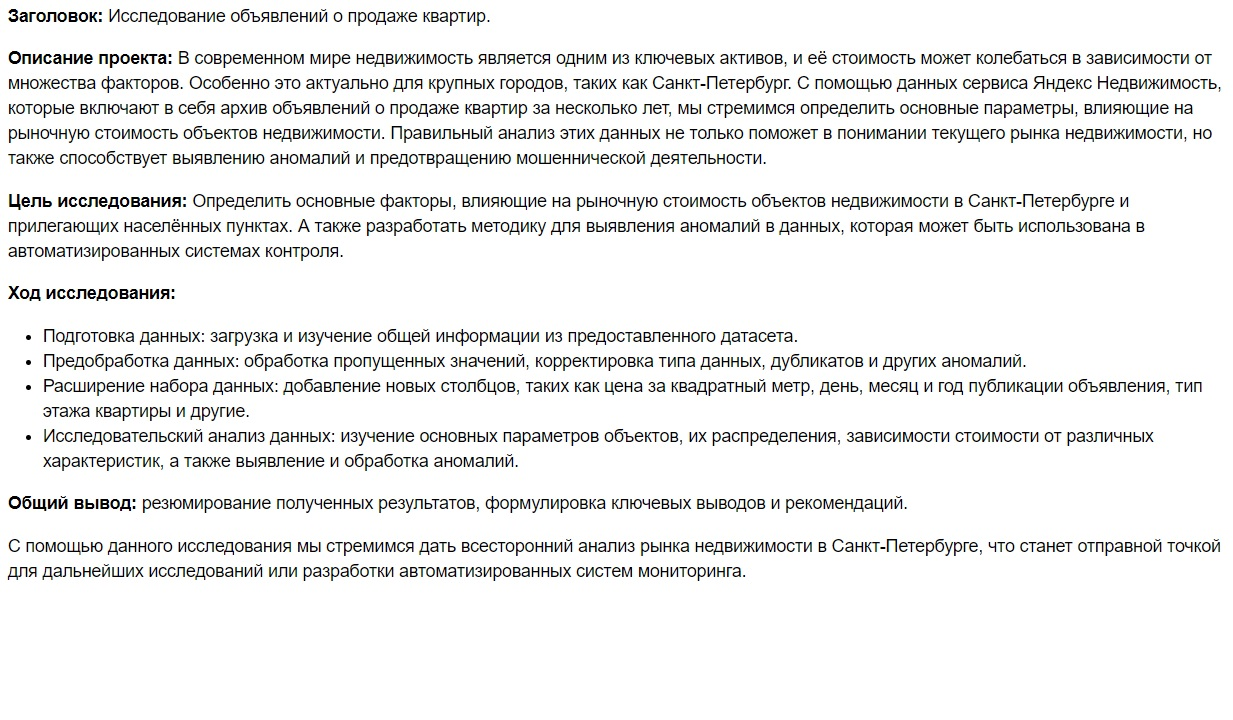
    
  
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила вступление. 
</div>

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
👍 
Супер!
</div>

## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
import matplotlib.pyplot as plt

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Правильно, что весь импорт ты проводишь в первой ячейке работы. Так твой коллега, запускающий работу, будет в курсе используемых в ней библиотек и сможет при необходимости быстро настроить окружение.
</div>

In [2]:
games = pd.read_csv('/datasets/games.csv')
display(games.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Вывод:
- Некорректные названия столбцов
- Неправильные типы данных по некоторым столбцам
- Есть пропуски
- Проверим на дубликаты

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Хорошая вводная часть.

Рекомендую создать универсальную функцию, которая будет принимать на вход датафрейм, а на выходе она будет выводить всего нужные характеристики, например, head, describe, info, дубликаты и т.п.
</div>

## Подготовим данные

In [5]:
#Приведем к нижнему регистру названия столбцов
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
# Преобразуем данные к нужному типу
# столбец year_of_release - тип object заменим на int
games['year_of_release'] = pd.array(games['year_of_release'], dtype = pd.Int64Dtype())

In [7]:
# Обработаем пропуски
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
Также, помимо абсолютных значений мы можем посмотреть долю пропусков, и на основании этого принять решение о удалении, замене либо игнорировании пропусков, например: `pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')`
    
    
</div>

In [8]:
pd.DataFrame(round(games.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


- столбец 'name' имеет  2 пропуска. **Удалим.**
- столбец 'genre' имеет  2 пропуска. **Удалим.**
- столбец 'year_of_release' - 269 пропусков. Год выпуска находится между 1980 и 2016. Так как к определенному году привяжется 269 дополнительных игр, при замене средним или медианным значением дальнейший анализ будет недостоверным. **Удалим.**
- столбцы 'critic_score', 'user_score' - это оценочные показатели. Не можем заменить пропуски средним или медианным значением. Также нельзя заменить пропуски нулями. Оставим, как есть.
- столбец 'rating' имеет 6766 пропусков. Значения этого столбца понадобятся нам для анализа, заменим пропуски значением 'no_rating'.

Пропуски в перечисленных столбцах могли появиться из-за человеческого фактора (неправильный ввод данных), также из-за технических проблем (ошибка при сохранении файла, при его отправке).

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
В name, genre  и year_of_release доля пропусков менее 5% и мы вполне можем их удалить.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила.
</div>

In [9]:
# Удалим пропуски в столбцах name, genre, year_of_release
games = games.dropna(subset=['name', 'genre', 'year_of_release'])

In [10]:
# в поле 'rating' заменим пропуски
games['rating'] = games['rating'].fillna('no_rating')
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating                0
dtype: int64

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Верное решение
</div>

In [11]:
# Проверим данные на дубликаты
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [12]:
games['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [13]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [14]:
# Посмотрим на строки со значением tbd
games.query('user_score == "tbd"').sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5253,Press Your Luck 2010 Edition,Wii,2009,Misc,0.33,0.00,0.0,0.03,NaN,tbd,E
6036,Karaoke Revolution Glee: Volume 3,Wii,2011,Misc,0.23,0.04,0.0,0.02,NaN,tbd,T
4429,Puppy Luv: Spa and Resort,DS,2007,Simulation,0.40,0.00,0.0,0.03,NaN,tbd,E
3678,ZhuZhu Pets 2: Featuring The Wild Bunch,DS,2010,Simulation,0.40,0.10,0.0,0.04,NaN,tbd,E
6575,The Penguins of Madagascar,DS,2010,Action,0.12,0.11,0.0,0.02,NaN,tbd,E


Значение 'tbd' означаем отсутствие оценки (если информации нет). Заменим 'tbd' на 'nan'. Тип данных столбца заменим на float.

In [15]:
games.loc[games['user_score'] == 'tbd','user_score'] = np.nan
games['user_score'] = games['user_score'].astype('float')

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 Верно, `tbd` означает `To Be Determined`, т.к. игра ещё не выпущена. Тут можно заменить заглушкой, а можно привести в nan
</div>

In [16]:
# Проверим таблицу на явные дубликаты
games.duplicated().sum()

0

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Молодец, что не забываешь про явные дубликаты.
</div>

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
Мы также должны учесть возможность наличия неявных дубликатов, которые могут возникнуть, если данные были собраны из разных источников или при возникновении технических ошибок. Учитывая, что мы уже привели названия столбцов к нижнему регистру, предлагаю провести проверку на дубликаты, основываясь на столбцах `'name', 'platform' и 'year_of_release'.`

Пожалуйста, выполни эту проверку и определи наличие неявных дубликатов, а также необходимо принять решение, как с ними поступить.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила. 
</div>

In [17]:
list(games['name'].unique())

['Wii Sports',
 'Super Mario Bros.',
 'Mario Kart Wii',
 'Wii Sports Resort',
 'Pokemon Red/Pokemon Blue',
 'Tetris',
 'New Super Mario Bros.',
 'Wii Play',
 'New Super Mario Bros. Wii',
 'Duck Hunt',
 'Nintendogs',
 'Mario Kart DS',
 'Pokemon Gold/Pokemon Silver',
 'Wii Fit',
 'Kinect Adventures!',
 'Wii Fit Plus',
 'Grand Theft Auto V',
 'Grand Theft Auto: San Andreas',
 'Super Mario World',
 'Brain Age: Train Your Brain in Minutes a Day',
 'Pokemon Diamond/Pokemon Pearl',
 'Super Mario Land',
 'Super Mario Bros. 3',
 'Grand Theft Auto: Vice City',
 'Pokemon Ruby/Pokemon Sapphire',
 'Brain Age 2: More Training in Minutes a Day',
 'Pokemon Black/Pokemon White',
 'Gran Turismo 3: A-Spec',
 'Call of Duty: Modern Warfare 3',
 'Pokémon Yellow: Special Pikachu Edition',
 'Call of Duty: Black Ops 3',
 'Call of Duty: Black Ops',
 'Pokemon X/Pokemon Y',
 'Call of Duty: Black Ops II',
 'Call of Duty: Modern Warfare 2',
 'Grand Theft Auto III',
 'Super Smash Bros. Brawl',
 'Mario Kart 7',
 'Ani

In [18]:
list(games['year_of_release'].unique())

[2006,
 1985,
 2008,
 2009,
 1996,
 1989,
 1984,
 2005,
 1999,
 2007,
 2010,
 2013,
 2004,
 1990,
 1988,
 2002,
 2001,
 2011,
 1998,
 2015,
 2012,
 2014,
 1992,
 1997,
 1993,
 1994,
 1982,
 2016,
 2003,
 1986,
 2000,
 1995,
 1991,
 1981,
 1987,
 1980,
 1983]

Неявных дубликатов не обнаружено.

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
📝 
Не совсем. Не забывай, что мы можем работать с набором столбцов и смотреть данные на пересечении. Ниже привел пример, как это можно реализовать.
</div>

In [19]:
#Код ревьюера

games[games[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [20]:
# Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16271,San-X Character Channel: All-Star Daishuugou!,DS,2008,Action,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01
9480,Venetica,X360,2010,Role-Playing,0.09,0.03,0.00,0.01,42.0,7.3,T,0.13
13703,Hellboy: The Science of Evil,PSP,2008,Action,0.04,0.00,0.00,0.00,42.0,7.1,T,0.04
9301,ESPN MLB Baseball,XB,2004,Sports,0.10,0.03,0.00,0.00,NaN,NaN,no_rating,0.13
2600,Pro Evolution Soccer 2016,PS4,2015,Sports,0.13,0.42,0.13,0.10,87.0,7.1,E,0.78


<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Отлично! Колонка с общими продажами создана. 
    
Также, мы можем работать с набором столбцов:</font><br>
`data = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)`
</div>

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
К сожалению отсутствует промежуточный вывод о проделанной работе в разделе. Дополни, пожалуйста.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила. 
</div>

**Вывод:**
- выполнена проверка на дубликаты, их не обнаружено
- приведены к нижнему регистру названия столбцов
- данные преобразованы к нужному типу
- обработаны пропуски

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
👍 

</div>

## Проведем исследовательский анализ данных

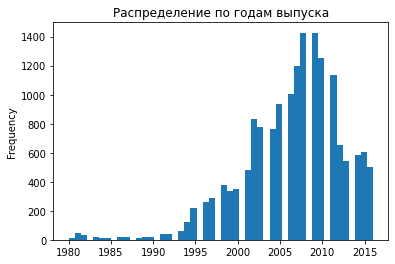

In [21]:
# Посмотрим, сколько игр выпускалось в разные годы.
games['year_of_release'].plot(kind = 'hist',bins = 50)
plt.title('Распределение по годам выпуска')
plt.show()

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
При работе с временными данными, особенно когда речь идет о визуализации, важно выбирать правильные методы представления информации.

* Линейные графики и столбчатые диаграммы - лучший выбор для временных рядов. Они показывают динамику изменений во времени и позволяют легко уловить тренды и аномалии.

* Гистограммы - полезны для демонстрации распределения данных. Однако нужно быть осторожным при использовании гистограмм для временных данных. Неправильный выбор интервалов может исказить восприятие данных. Если использовать гистограмму, то необходимо тщательно выберать интервалы.



Ключ к успешной визуализации - в понимании датасета и выборе правильных инструментов для демонстрации ключевой информации.
</div>

Игры начали выпускаться с 1980 года. До 1995 сфера особо не развивалась, поэтому данные до этого года не важны для анализа.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
С выводом согласен
</div>

In [22]:
# Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение 
# по годам. 
# За какой характерный срок появляются новые и исчезают старые платформы?
#построим сводную таблицу 
sales_by_platform =games.pivot_table(
                                 index = ['platform'], 
                                 values = ['total_sales'],
                                 aggfunc =  ['sum']).sort_values(('sum', 'total_sales'),ascending = False)
display(sales_by_platform)

,sum
,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88


Платформы с наибольшими суммарными продажами: PS2, X360, PS3, Wii, DS, PS.

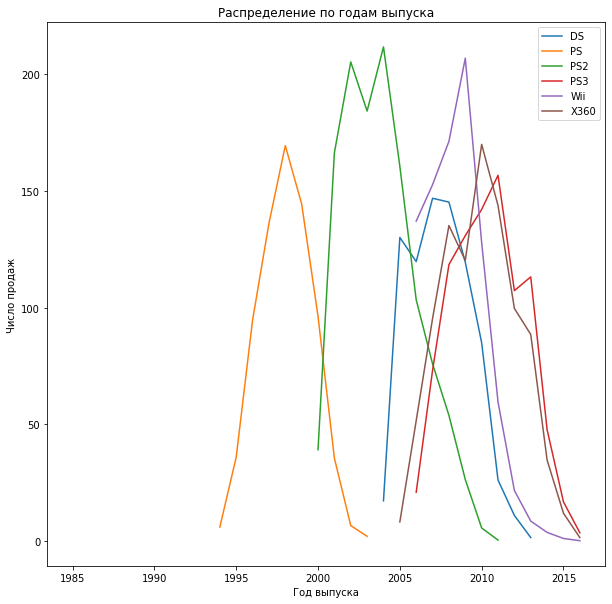

In [23]:
# Построим распределение по годам.
top_sales_platform_df = games.query('platform == ["PS2","X360","PS3","Wii","DS","PS"]')
top_platforms_by_years =top_sales_platform_df.pivot_table(
                                 index = ['year_of_release'], 
                                 columns = ['platform'],
                                 values = ['total_sales'],
                                 aggfunc =  ['sum'])
top_platforms_by_years.plot(figsize = (10,10), legend=True, xlabel="Год выпуска", ylabel="Число продаж")
plt.legend(["DS", "PS", "PS2", "PS3", "Wii", "X360"]);
plt.title('Распределение по годам выпуска')
plt.show()

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
Обрати, пожалуйста, внимание на оформление графиков в проекте. Важно, чтобы у каждого графика было название, а оси были четко подписаны. Пожалуйста, пройдись по всем графикам и убедись в их корректном оформлении.
    
Помни, график — это инструмент общения с заказчиком. Он должен быть ясным, лаконичным и информативным.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила. 
</div>

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
✍
Только заголовка у графика так и нет :( Прошу тебя пройтись по всем графикам и дать графикам названия.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Добавила заголовок к графику. 
</div>

Срок появления новых и исчезания старых платформ - примерно 10 лет.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Жизненный цикл определен верно.
</div>

По графику доходные платформы теряют продажи к 2015 году. Актуальным периодом можно считать - 8 лет. 

In [24]:
# Возьмем данные за соответствующий актуальный период.
actual_games = games.query('year_of_release > 2012')
display(actual_games)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no_rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,no_rating,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no_rating,0.01


<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
Для целей прогнозирования продаж на следующий год даже в традиционных бизнесах редко берут данные более чем за 2-3 года. А в такой динамично меняющейся индустрии, как компьютерные игры и вовсе не стоит брать слишком большой временной интервал - иначе обязательно захватим уже отжившие тренды. Но и очень короткий период не подходит для прогнозирования, так что надо выбирать золотую середину (но не менее 2-х полных лет и не более 5 лет). Так, как все расчеты ниже необходимо использовать с актуальным периодом, то не забудь, пожалуйста перепроверить их и выводы после корректировки.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила. 
</div>

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
👍 
Верно
</div>

In [25]:
# Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
actual_games['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

In [26]:
# Оценим продажи по этим платформам
sales_by_actual_platforms =actual_games.pivot_table(
                                 index = ['platform'], 
                                 values = ['total_sales'],
                                 aggfunc =  ['sum'])
sales_by_actual_platforms.sort_values(('sum', 'total_sales'),ascending = False)

,sum
,total_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99


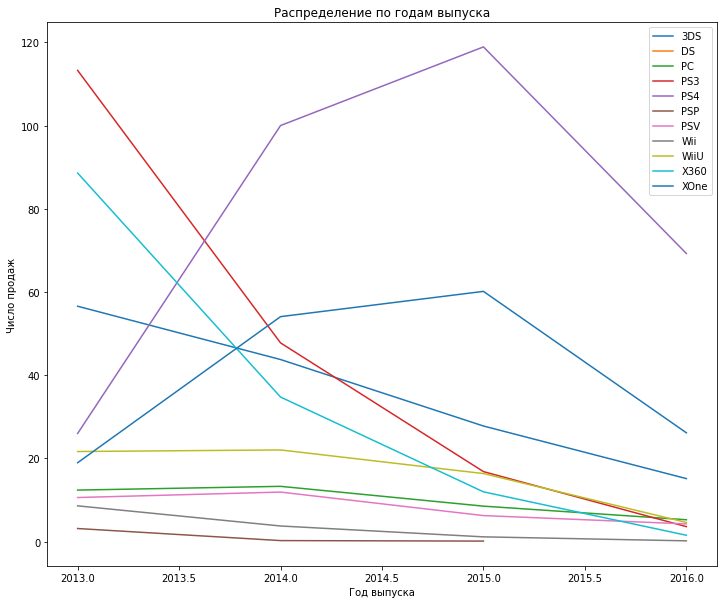

In [27]:
top_platforms_actual_df =actual_games.pivot_table(
                                 index = ['year_of_release'], \
                                 columns = ['platform'],
                                 values = ['total_sales'],
                                 aggfunc =  ['sum'])
top_platforms_actual_df.plot(figsize = (12,10), xlabel="Год выпуска", ylabel="Число продаж")
plt.legend(["3DS", "DS", "PC", "PS3", "PS4", "PSP", "PSV", "Wii", "WiiU", "X360", "XOne"]);
plt.title('Распределение по годам выпуска')
plt.show()

Большинство платформ теряют продажи к 2016 году. Прибыльными можно считать PS4 и XOne.

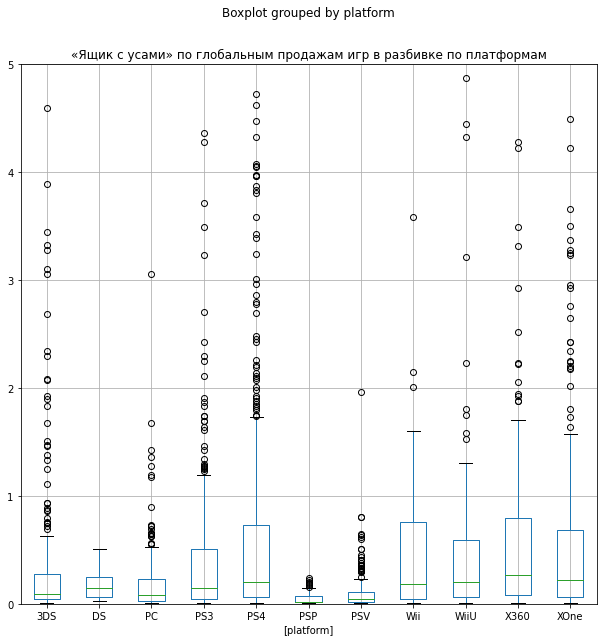

In [28]:
# Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.
actual_games.boxplot(column=['total_sales'], 
                     by=['platform'],figsize=(10, 10))
plt.ylim([0, 5])
plt.title('«Ящик с усами» по глобальным продажам игр в разбивке по платформам')
plt.show()

- Медианы продаж XOne и PS4 находятся примерно на одном уровне. 
- Сразу бросается в глаза **PS4**, **XOne**, **PS3**, **3DS**. Но учитывая предыдущий график, игры для платформ **3DS** и **PS3** теряют популярность.
**Вывод:** Самые продаваемые игры - игры для PS4 и XOne

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍  
Давай дополним твой вывод. В этом модуле нам важно научиться работать с боксплотами и анализировать их. В твоём выводе стоит упомянуть про распределения и выбросы, например, очень популярные игры.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила. 
</div>

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
👍 

</div>

In [29]:
# Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
# Построим диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами.

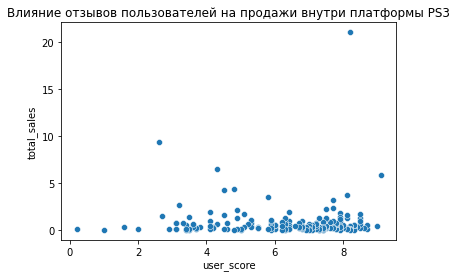

In [30]:
# Посмотрим, как влияют на продажи внутри платформы PS3 отзывы пользователей. 
ps3_df = actual_games.query('platform == "PS3"').sort_values('user_score', ascending = False)
ps3_user_score = sns.scatterplot(data=ps3_df, x='user_score',y='total_sales').set(title="Влияние отзывов пользователей на продажи внутри платформы PS3")

In [31]:
# Коэффициент корреляции 
ps3_df['user_score'].corr(ps3_df['total_sales'])

0.0023944027357566773

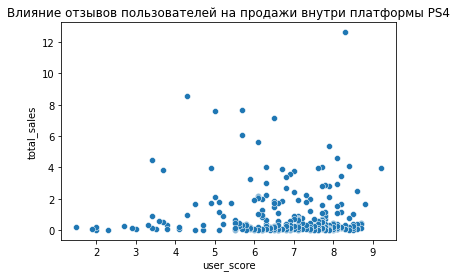

In [32]:
# Посмотрим, как влияют на продажи внутри платформы PS4 отзывы пользователей. 
ps4_df = actual_games.query('platform == "PS4"').sort_values('user_score', ascending = False)
ps4_user_score = sns.scatterplot(data=ps4_df, x='user_score',y='total_sales').set(
    title="Влияние отзывов пользователей на продажи внутри платформы PS4")

In [33]:
# Коэффициент корреляции 
ps4_df['user_score'].corr(ps4_df['total_sales'])

-0.031957110204556424

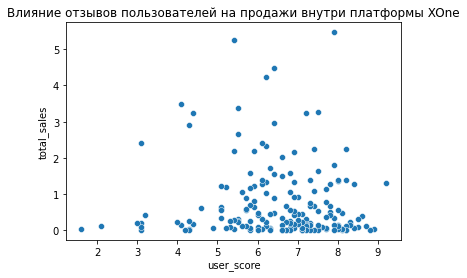

In [34]:
# Посмотрим, как влияют на продажи внутри платформы XOne отзывы пользователей. 
xone_df = actual_games.query('platform == "XOne"').sort_values('user_score', ascending = False)
xone_user_score = sns.scatterplot(data=xone_df, x='user_score',y='total_sales').set(
    title="Влияние отзывов пользователей на продажи внутри платформы XOne")

In [35]:
# Коэффициент корреляции 
xone_df['user_score'].corr(xone_df['total_sales'])

-0.06892505328279423

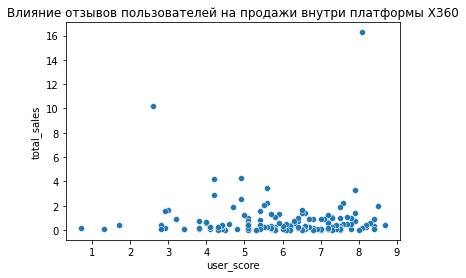

In [36]:
# Посмотрим, как влияют на продажи внутри платформы X360 отзывы пользователей. 
x360_df = actual_games.query('platform == "X360"').sort_values('user_score', ascending = False)
x360_user_score = sns.scatterplot(data=x360_df, x='user_score',y='total_sales').set(
    title="Влияние отзывов пользователей на продажи внутри платформы X360")

In [37]:
# Коэффициент корреляции 
x360_df['user_score'].corr(x360_df['total_sales'])

-0.011742185147181356

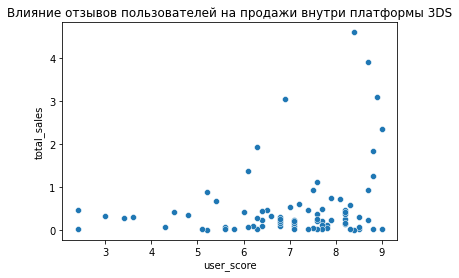

In [38]:
# Посмотрим, как влияют на продажи внутри платформы 3DS отзывы пользователей. 
three_ds_df = actual_games.query('platform == "3DS"').sort_values('user_score', ascending = False)
three_ds_user_score = sns.scatterplot(data=three_ds_df, x='user_score',y='total_sales').set(
    title="Влияние отзывов пользователей на продажи внутри платформы 3DS")

In [39]:
# Коэффициент корреляции 
three_ds_df['user_score'].corr(three_ds_df['total_sales'])

0.2415041177356301

Оценки пользователей не влияют на продажи. Коэффициент корреляции примерно равен 0.

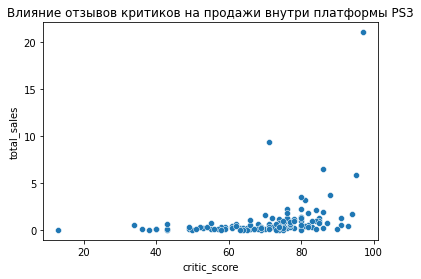

In [40]:
# Посмотрим, как влияют на продажи внутри платформы PS3 отзывы критиков. 
ps3_critic_score = sns.scatterplot(data=ps3_df, x ='critic_score', y='total_sales').set(
    title="Влияние отзывов критиков на продажи внутри платформы PS3")

In [41]:
# Коэффициент корреляции 
ps3_df['critic_score'].corr(ps3_df['total_sales'])

0.33428533933719184

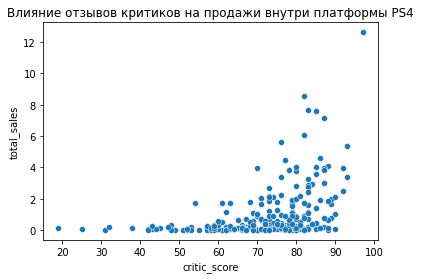

In [42]:
# Посмотрим, как влияют на продажи внутри платформы PS4 отзывы критиков. 
ps4_critic_score = sns.scatterplot(data=ps4_df, x ='critic_score', y='total_sales').set(
    title="Влияние отзывов критиков на продажи внутри платформы PS4")

In [43]:
# Коэффициент корреляции 
ps4_df['critic_score'].corr(ps4_df['total_sales'])

0.40656790206178134

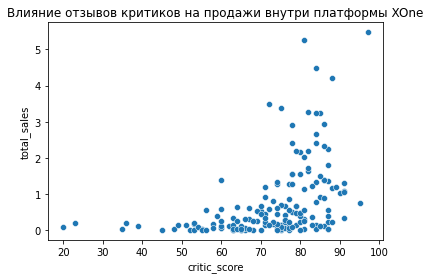

In [44]:
# Посмотрим, как влияют на продажи внутри платформы XOne отзывы критиков. 
xone_critic_score = sns.scatterplot(data=xone_df, x ='critic_score', y='total_sales').set(
    title="Влияние отзывов критиков на продажи внутри платформы XOne")

In [45]:
# Коэффициент корреляции 
xone_df['critic_score'].corr(xone_df['total_sales'])

0.4169983280084016

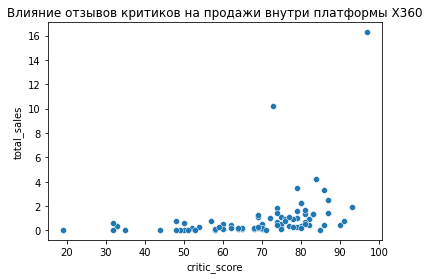

In [46]:
# Посмотрим, как влияют на продажи внутри платформы X360 отзывы критиков. 
x360_critic_score = sns.scatterplot(data=x360_df, x ='critic_score', y='total_sales').set(
    title="Влияние отзывов критиков на продажи внутри платформы X360")

In [47]:
# Коэффициент корреляции 
x360_df['critic_score'].corr(x360_df['total_sales'])

0.3503445460228664

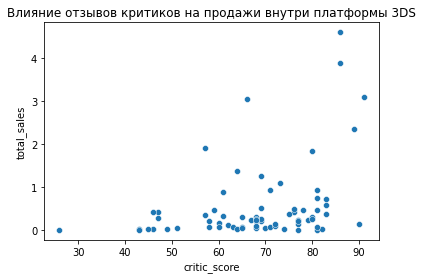

In [48]:
# Посмотрим, как влияют на продажи внутри платформы 3DS отзывы критиков. 
three_ds_critic_score = sns.scatterplot(data=three_ds_df, x ='critic_score', y='total_sales').set(
    title="Влияние отзывов критиков на продажи внутри платформы 3DS")

In [49]:
# Коэффициент корреляции 
three_ds_df['critic_score'].corr(three_ds_df['total_sales'])

0.35705661422881046

Корреляция больше, чем в случае с оценками пользователей, но ее недостаточно, чтобы говорить о прямой зависимости.

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
В задании нас просят: **Проанализируйте продажи игр на различных платформах.** Рекомендуется строить диаграммы рассеяния для нескольких платформ, а не просто опираться на расчет корреляции. Делая выводы на основе данных по пяти или более платформам, наш анализ будет более углубленным и убедительным. Для упрощения задачи, можно применить цикл.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила. 
</div>

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
👍 

</div>

Оценки пользователей никак не влияют на продажи. 
Оценки критиков немного влияют на продажи, но говорить о прямой зависимости нельзя.

In [50]:
# Посмотрим на общее распределение игр по жанрам. 
# Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?
popular_genre = actual_games.groupby('genre').agg({'name':'count'})
popular_genre.sort_values(by='name', ascending=False)

,name
genre,
Action,766
Role-Playing,292
Adventure,245
Sports,214
Shooter,187
Misc,155
Racing,85
Fighting,80
Platform,74


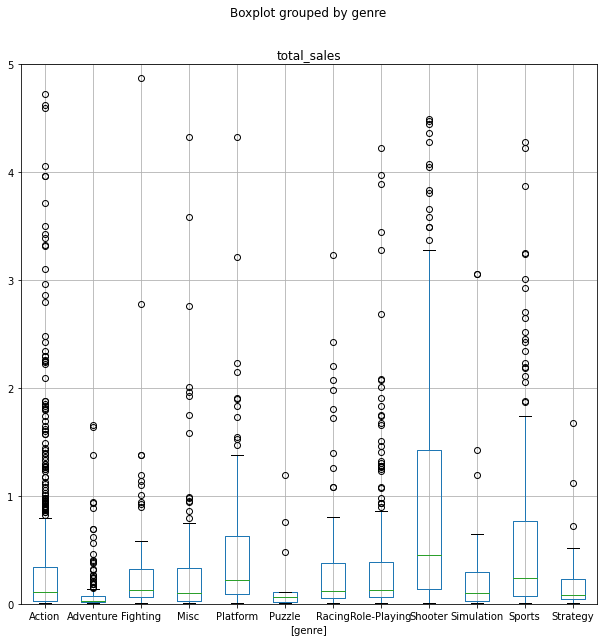

In [51]:
actual_games.boxplot(column = ['total_sales'],by = ['genre'],figsize=(10, 10))
plt.ylim([0, 5])
plt.show()

В жанре Action очень много выбросов. Из-за этого общая прибыль по этому жанру больше остальных.

Медианное значение жанра Shooter выше. Значит, можно предположить, что этот жанр самый прибыльный.



<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Верно. Общие продажи - плохая метрика для поиска наиболее прибыльного жанра. За высокими показателями общих продаж может скрываться множество мелких игр с низкими продажами. Или 2-3 звезды и куча провалов. Лучше найти жанр, где игры стабильно приносят высокий доход - для этого стоит рассматривать средние или медианные продажи.
</div>

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
Но, из вывода все же не совсем понятно, какой жанр можно назвать самым прибыльным?
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила. 
</div>

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
👍 
Совершенно верно
</div>

## Составим портрет пользователя каждого региона

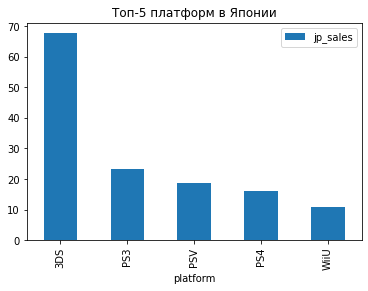

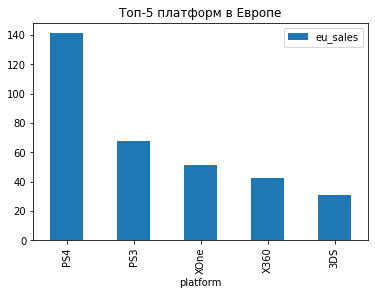

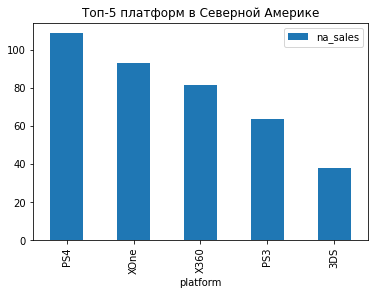

In [52]:
# Самые популярные платформы (топ-5)
actual_games.groupby(by='platform').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head().plot(kind='bar', title="Топ-5 платформ в Японии")
actual_games.groupby(by='platform').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head().plot(kind='bar', title="Топ-5 платформ в Европе")
actual_games.groupby(by='platform').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head().plot(kind='bar', title="Топ-5 платформ в Северной Америке")
plt.show()

- Для пользователей из Японии самые популярные платформы: 3DS, PS3, PSV, PS4, WiiU;
- Для пользователей из Европы самые популярные платформы: PS4, PS3, XOne, X360, 3DS;
- Для пользователей из Северной Америки самые популярные платформы: PS4, XOne, X360, PS3, 3DS;

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
Исходя из расчетов вывод верный, но после корректировки актуальног оперида данные могут измениться.

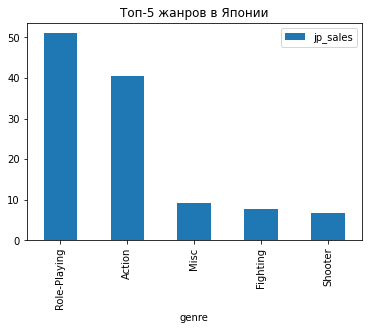

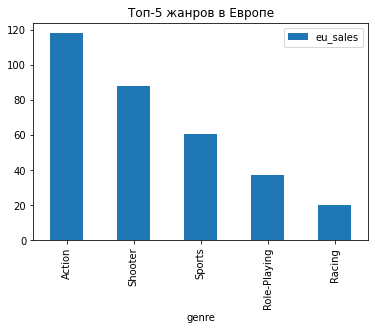

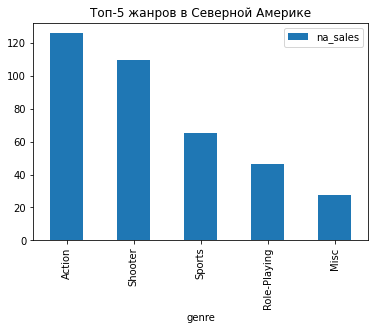

In [53]:
# Самые популярные жанры (топ-5)
actual_games.groupby(by='genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head().plot(kind='bar', title="Топ-5 жанров в Японии")
actual_games.groupby(by='genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head().plot(kind='bar', title="Топ-5 жанров в Европе")
actual_games.groupby(by='genre').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head().plot(kind='bar', title="Топ-5 жанров в Северной Америке")
plt.show()

- Для пользователей из Японии самые популярные жанры: Role-Playing, Action, Misc, Fighting, Shooter;
- Для пользователей из Европы самые популярные жанры: Action, Shooter, Sports, Racing, Role-Playing;
- Для пользователей из Северной Америки самые популярные жанры: Action, Shooter, Sports, Misc, Role-Playing;

Можно отметить, что топ-жанров для пользователей Европы и Северной Америки объединяют жанры Action, Shooter, Sports и Role-Playing

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Согласен, NA и EU во многом схожи, в то время, как Япония более самобытна.
</div>

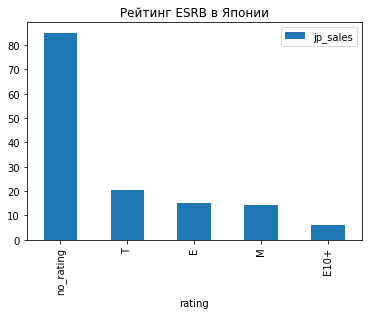

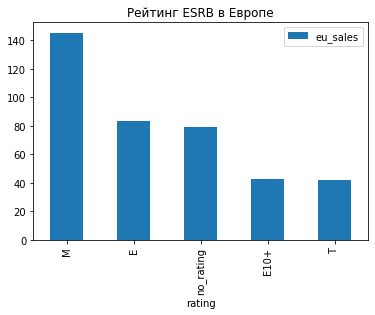

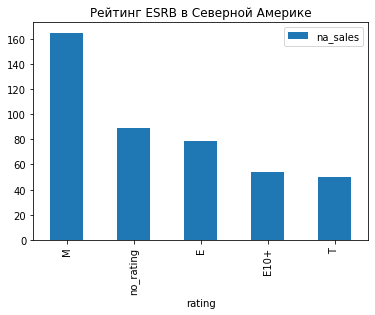

In [54]:
# Влияет ли рейтинг ESRB на продажи в отдельном регионе?
actual_games.groupby(by='rating').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head().plot(kind='bar', title="Рейтинг ESRB в Японии")
actual_games.groupby(by='rating').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head().plot(kind='bar', title="Рейтинг ESRB в Европе")
actual_games.groupby(by='rating').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head().plot(kind='bar', title="Рейтинг ESRB в Северной Америке")
plt.show()

- В Северной Америке и Европе первую пятерку составляют игры рейтинга М, E, no_rating, E10+, T. 
- В Японии же с огромным преимуществом пользуются игры без рейтинга. Скорее всего в Японии свой рынок игр и они просто не оцениваются организацией ESRB.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Правильно, что мы при предобработке данных поставили заглушку на пропуски в рейтинге ESRB. Иначе игры без рейтинга оказались бы полностью исключенными из анализа. Продажи именно этих игр могут указать на ключевое различие в регионах.
</div>

## Проверим гипотезы

In [55]:
# Проверим гипотезу: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Сформулируем нулевую и альтернативную гипотезы:

- Н0: Средний пользовательский рейтинг платформ Xbox One и PC одинаковый
- H1: Средний пользовательский рейтинг платформ Xbox One и PC различается

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
Гипотезы сформулированы верно.
</div>

Будем использовать t-критерий Стьюдента, так как наши выборки независимы между собой.

In [56]:
alpha = .05
xbox_one = actual_games[(actual_games['platform'] == 'XOne') & (actual_games['user_score'] > 0)]['user_score']
pc = actual_games[(actual_games['platform'] == 'PC') & (actual_games['user_score'] > 0)]['user_score']

In [57]:
test = st.ttest_ind(xbox_one, pc)
print('p-value:', test.pvalue)

if (test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.14012658403611647
Не получилось отвергнуть нулевую гипотезу


Не можем отвергнуть нулевую гипотезу. Это значит, что значимой разницы между пользовательским рейтингом двух платформ (Xbox One и PC) нет. 

In [58]:
# Проверим гипотезу: Средние пользовательские рейтинги жанров Action и Sports разные.

Сформулируем нулевую и альтернативную гипотезы:

- Н0: Средние пользовательские рейтинги жанров Action и Sports равны
- H1: Средние пользовательские рейтинги жанров Action и Sports различаются

Здесь также используем  t-критерий Стьюдента.

In [59]:
action = actual_games[(actual_games['genre'] == 'Action') & (actual_games['user_score'] > 0)]['user_score']
sport = actual_games[(actual_games['genre'] == 'Sports') & (actual_games['user_score'] > 0)]['user_score']

In [60]:
test = st.ttest_ind(action, sport)
print('p-value:', test.pvalue)

if (test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


Отвергаем нулевую гипотезу, это значит, что пользовательские рейтинги жанров Action и Sports различаются.

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
👍 
* Правильно, что для тестирования гипотез использован двусторонний t-тест Стьюдента.

* Хорошо, что использован параметр отфильтровывющий пропуски. 
</div>

<div class="alert alert-warning" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
📝 
Также можно вывести не только pvalue, но еще и средние значения выборок, которые мы изучаем. Это позволит нам проверить не ошиблись ли мы, если они расходятся с тестом Стьюдента.
</div>

# Общий вывод

Успешность игры определяют следующие параметры:
  - Регион
  - Платформа, которая наиболее распространена в данном регионе
  - Жанр
  - Рейтинг критиков
  
**Игры, которые будут продаваться в Северной Америке лучше всего:**
- ESRB: M, E, без рейтинга
- Платформа: PS4, XOne, Xbox360, PS3, 3DS
- Жанры: Action, Shooter, Sports, Role-Playing, Misc

**Игры, которые будут продаваться в Европе лучше всего:**
- ESRB: E, M, без рейтинга
- Платформы:  PS4, PS3, XOne, X360, 3DS
- Жанры: Action, Shooter, Sports, Role-Playing, Racing

**Игры, которые будут продаваться в Японии лучше всего:**
- ESRB: E, T, без рейтинга
- Платформы: DS, 3DS, PS3, PSP, Wii
- Жанры: Role-Playing, Action, Misc, Fighting, Shooter

<div class="alert alert-danger" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.1</b> 
    
✍ 
В общем и целом вывод верный. Однако для большей наглядности для заказчика предлагаю структурировать итоговые выводы, выделяя ключевые аспекты работы. В финальном разделе стоит максимально детализировать и обогатить информацией с конкретными цифрами все найденные закономерности и особенности в данных в ходе исследования.

Давай сделаем обзорную часть более развернутой, чтобы подчеркнуть качество проведенной работы и предоставить заказчику полное понимание проведенного анализа.
</div>

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
Исправила. 
</div>

<div class="alert alert-success" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
<b>Комментарий ревьюера v.2</b> 
    
👍 
Выводы понятны и логичны, а самое главное подкреплены выявленными фактами.
    
Ты очень серьезно подходишь к визуализации.

Вот пара ссылок на полезные источники:https://habr.com/ru/company/otus/blog/540526/, https://pythonru.com/biblioteki/seaborn-plot
</div>

<div style="border:solid blue 3px; padding: 20px">
<div class="alert alert-success">
<b>Обратная связь v.1</b> 
    
👋
Анна, замечательная работа, ты мыслишь нестандартно, это отличный навык, который у тебя уже есть, ты последовательна и вдумчива. Твою работу очень интересно читать и проверять.  Я оставил несколько обязательных поправок для тебя и после этого буду готов сразу принять проект. 

Удачи в доработках, жду! 

<div style="border:solid blue 3px; padding: 20px">
<div class="alert alert-success">
<b>Обратная связь v.2</b> 
    
👋 
Анна, спасибо, что прислала работу на повторное ревью. По проекту нам осталось только озаглавить графики, это очень важный момент. Прошу тебя реализовать и прислать проект на проверку.

<div class="alert alert-info" style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px "> 
<b>Комментарий студента</b> 
К графикам добавила заголовки.
</div>

<div style="border:solid indigo 3px; padding: 20px">
<div class="alert alert-success">
<b>Обратная связь v.3</b> 
    
👋 
      
Анна, спасибо тебе за исправления критических моментов, а также спасибо за хорошую работу.
    
Поздравляю с успешным завершением проекта 🥳 🎉
    
И желаю успехов в новых работах 😊